<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/Water-Body/blob/main/Water_Body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install xee -q

In [2]:
import ee
import geemap
import xarray as xr
import xee
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [3]:
ee.Authenticate()
ee.Initialize(project="your project name ", opt_url='https://earthengine-highvolume.googleapis.com')

In [4]:
map=geemap.Map(basemap="SATELLITE")
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

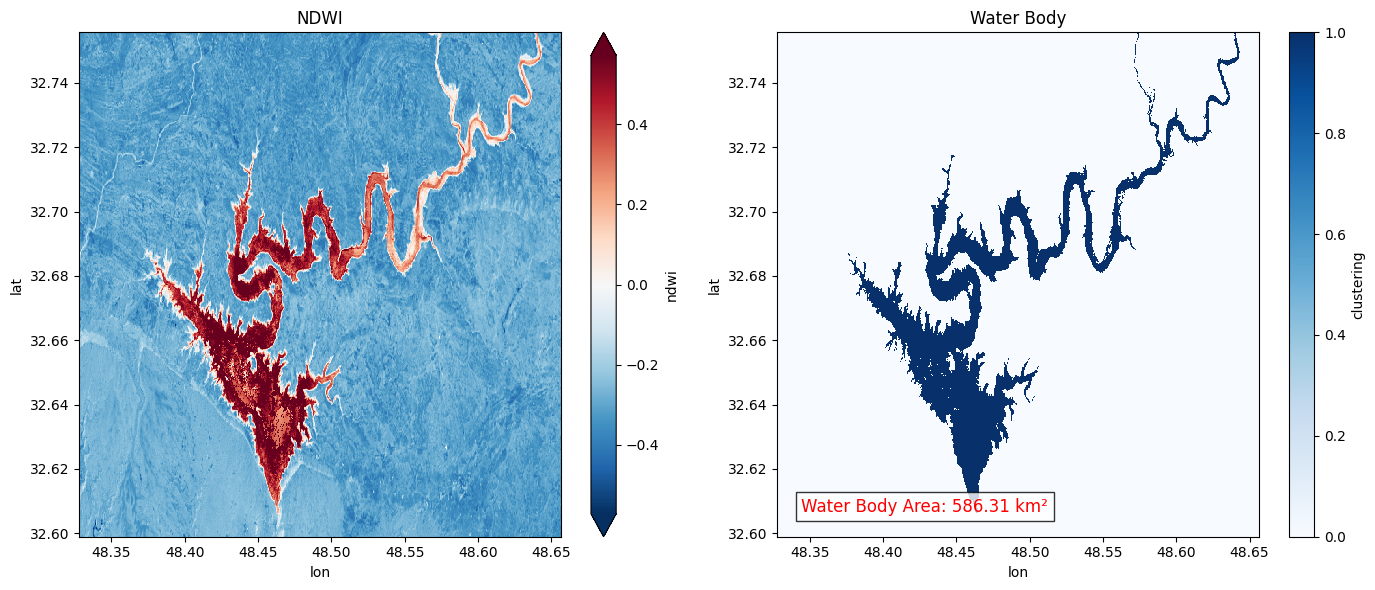

In [12]:
roi = map.draw_last_feature.geometry()


start_time = '2020'

end_time = '2021'


landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(roi).filterDate(start_time,end_time)

def ndwi(img):
  qa = img.select('QA_PIXEL')
  cloud = qa.bitwiseAnd(1 << 3).neq(0)
  cirrus = qa.bitwiseAnd(1 << 2).neq(0)
  shadow = qa.bitwiseAnd(1 << 4).neq(0)
  mask = cloud.Or(cirrus).Or(shadow)
  bands = img.select('SR.*').multiply(2.75e-05).add(-0.2)
  index = bands.normalizedDifference(['SR_B3','SR_B5']).rename('ndwi')
  return index.updateMask(mask.Not()).copyProperties(img, img.propertyNames())

landsat_ndwi = landsat.map(ndwi)
landsat_ndwi

ds = xr.open_dataset(landsat_ndwi, engine = 'ee', crs = 'EPSG:4326', scale = 0.000269, geometry = roi)

ds_mean = ds.mean('time')

model = KMeans(n_clusters = 2, random_state = 42)

df = ds_mean.to_dataframe()

df['clustering'] = model.fit_predict(df[['ndwi']])

xarr = df.to_xarray().sortby('lon').sortby('lat')
xarr

lake_pixels = (xarr.clustering == 0).sum(dim = ['lon','lat'])
lake_area = (lake_pixels * 300 * 300) / 1e6

# Create the figure and axes
# Count lake pixels
lake_pixels = (xarr.clustering == 0).sum().item()

# Convert to square kilometers
lake_area_km2 = lake_pixels * 900 / 1_000_000  # each pixel = 900 m²

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Plot mean NDWI
ds_mean.ndwi.plot(ax=axes[0], x='lon', y='lat', robust=True)
axes[0].set_title("NDWI")

# Plot clustering
xarr.clustering.plot(ax=axes[1], x='lon', y='lat', cmap='Blues')
axes[1].set_title("Water Body")

# Add lake area text in km²
axes[1].text(
    0.05, 0.05, f"Water Body Area: {lake_area_km2:.2f} km²",
    transform=axes[1].transAxes,
    fontsize=12, color='red',
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.show()